In [1]:
import torch
import os
import numpy as np
from copy import deepcopy
from few_shot_meta_learning.fsml.HyperNetClasses import IdentityNet, NormalVariationalNet
from few_shot_meta_learning.fsml.RegressionDataset import SineDataset, LineDataset
from few_shot_meta_learning.fsml._utils import train_val_split_regression
from matplotlib import pyplot as plt
%matplotlib inline
from few_shot_meta_learning.fsml.algorithms.Maml import Maml

In [2]:
from few_shot_meta_learning.benchmark_dataloader import create_benchmark_dataloaders

michael_config = {}
michael_config['bm'] = 'Quadratic1D' # Sinusoid1D, Affine1D
michael_config['noise_stddev'] = 0.01
michael_config['n_tasks_meta'] = 8 
michael_config['n_points_per_task_meta'] = 16 
michael_config['n_tasks_test'] = 128
michael_config['n_points_per_task_test'] = 128 
michael_config['seed_offset_train'] = 1234 
michael_config['seed_offset_test'] = 1235 
michael_config['normalize_bm'] = True # not used right now
michael_config['n_points_pred'] = 100 # not used right now
# training
michael_config['n_epochs'] = 500
michael_config['adapt_lr'] = 0.01
michael_config['meta_lr'] = 0.001
michael_config['n_adapt_steps'] = 5
michael_config['n_context_meta'] = 8

train_dataloader, test_dataloader = create_benchmark_dataloaders(michael_config)

In [3]:
config = {}

config['resume_epoch'] = 0
config['network_architecture'] = 'FcNet'
config['logdir'] = os.path.join('.', 'saved_models', 'fsml', 'maml', config['network_architecture'])

#config['datasource'] = ['SineLine']
config['num_ways'] = 1
config['k_shot'] = michael_config['n_context_meta']
config['v_shot'] = 10
config['num_models'] = 16
config['KL_weight'] = 1e-5

config['inner_lr'] = michael_config['adapt_lr']
config['num_inner_updates'] = michael_config['n_adapt_steps']
config['meta_lr'] = michael_config['meta_lr']

config['train_flag'] = False
config['num_episodes'] = 100 # for testing only
config['resume_epoch'] = 0
config['num_epochs'] = michael_config['n_epochs']
config['num_episodes_per_epoch'] = michael_config['n_tasks_meta']
config['minibatch'] = michael_config['n_tasks_meta']
config['minibatch_print'] = 1

# TODO
config['device'] = torch.device('cuda:0' if torch.cuda.is_available() else torch.device('cpu'))

config['loss_function'] = torch.nn.MSELoss()
config['train_val_split_function'] = train_val_split_regression

config['first_order'] = True

config['wandb'] = True
config['algorithm'] = 'maml'

maml = Maml(config)
maml.train(train_dataloader=train_dataloader, val_dataloader=None)
#model['f_base_net'].eval()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: leonjungemeyer (use `wandb login --relogin` to force relogin)


Training is started.
Log is stored at ./saved_models/fsml/maml/FcNet.

Number of parameters of the base network = 1,761.



/Users/leonjungemeyer/opt/anaconda3/envs/meta/lib/python3.9/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


State dictionaries are saved into ./saved_models/fsml/maml/FcNet/Epoch_100.pt

State dictionaries are saved into ./saved_models/fsml/maml/FcNet/Epoch_200.pt

State dictionaries are saved into ./saved_models/fsml/maml/FcNet/Epoch_300.pt

State dictionaries are saved into ./saved_models/fsml/maml/FcNet/Epoch_400.pt

State dictionaries are saved into ./saved_models/fsml/maml/FcNet/Epoch_500.pt

Training is completed.


In [17]:
resume_maml = 500
model = maml.load_model(resume_epoch=resume_maml, eps_dataloader=train_dataloader, hyper_net_class=IdentityNet)

Number of parameters of the base network = 1,761.



/Users/leonjungemeyer/opt/anaconda3/envs/meta/lib/python3.9/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


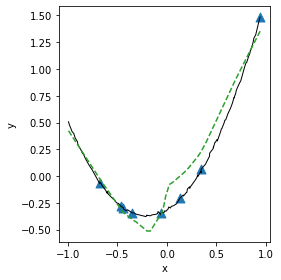

In [18]:
test_task_data = test_dataloader.dataset[13]
x_test, sort_indices = torch.sort(test_task_data[0])
y_test = test_task_data[1][sort_indices]

split_data = config['train_val_split_function'](eps_data=test_task_data, k_shot=config['k_shot'])

# move data to GPU (if there is a GPU)
x_t = split_data['x_t'].to(config['device']) # k_shot=8 
y_t = split_data['y_t'].to(config['device']) # k_shot=8

# MAML
adapted_hyper_net = maml.adaptation(x=x_t[:, None], y=y_t[:, None], model=model)
y_maml = maml.prediction(x=x_test[:, None], adapted_hyper_net=adapted_hyper_net, model=model)

# plot
plt.figure(figsize=(4, 4))
plt.scatter(x=x_t.cpu().numpy(), y=y_t.cpu().numpy(), s=80, marker='^', color='C0') # samples 
plt.plot(x_test.cpu().numpy(), y_test, color='black', linewidth=1, linestyle='-') # true task data
plt.plot(x_test.cpu().numpy(), y_maml.detach().cpu().numpy(), color='C2', linestyle='--')
plt.xlabel('x')
plt.ylabel('y')
plt.tight_layout()

plt.show()